Jupyter Lab tutorial: https://www.youtube.com/watch?v=A5YyoCKxEOU

Cheatsheet: https://cheatography.com/weidadeyue/cheat-sheets/jupyter-notebook/

In [1]:
import numpy as np
import pandas as pd
import psycopg2
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date, datetime, timedelta
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score

pd.options.mode.chained_assignment = None  # default='warn'

In [13]:
con = psycopg2.connect(
    dbname='dwh',
    user='piotrzawieja',
    host='dwh-production.db.in.vimcar.com',
    port=5432,
    password='Xt9d7PIQx6ujmWvBg82bMfASy4DsQwKzC5UYrhvxtiiiPIOTR1')


sql_customer = """

SELECT * 
FROM data_mart_internal_reporting.ir_ml_customer_revenue 
WHERE is_fleet = TRUE

"""

print('Executing sql_customer from Postgres...')
print('')
df_pg_customer = pd.read_sql(sql_customer, con)

df_pg_customer.head()

OperationalError: could not connect to server: Connection timed out (0x0000274C/10060)
	Is the server running on host "dwh-production.db.in.vimcar.com" (10.60.11.154) and accepting
	TCP/IP connections on port 5432?


In [111]:
sql_tickets = """

SELECT * FROM data_mart_internal_reporting.ir_ml_fleet_customer_tickets

"""

print('Executing sql_tickets from Postgres...')
df_pg_tickets = pd.read_sql(sql_tickets, con)

df_pg_tickets.head()

Executing sql_tickets from Postgres...


,domain_name,tickets_cs_amt,sat_score_cs,tickets_other_amt,sat_score_other,tickets_cs_last7d_amt,tickets_other_last7d_amt,created_at
0,com.vimcar.de.22393236,2,NaN,0,NaN,0,0,2021-04-06 13:50:19.295163+00:00
1,com.vimcar.de.44744367,2,NaN,0,NaN,0,0,2021-04-06 13:50:19.295163+00:00
2,com.vimcar.de.datenschutz-und-vereinsmanagement,2,1.0,0,1.0,0,0,2021-04-06 13:50:19.295163+00:00
3,com.vimcar.de.k11193397,1,NaN,0,NaN,0,0,2021-04-06 13:50:19.295163+00:00
4,com.vimcar.de.k12092921,0,NaN,3,NaN,0,0,2021-04-06 13:50:19.295163+00:00


In [112]:
sql_trips = """

SELECT * FROM data_mart_internal_reporting.ir_ml_fleet_customer_trips

"""

print('Executing sql_trips from Postgres...')
df_pg_trips = pd.read_sql(sql_trips, con)
con.close()

df_pg_trips.head()

Executing sql_trips from Postgres...


,domain_name,trips_2_mths_ago,trips_last_30_days,trips_development_abs,distance_development_pct,created_at
0,com.vimcar.3d-lasertec-gmbh-com,1086,908,-178,-22,2021-04-06 13:59:13.480603+00:00
1,com.vimcar.4radiology-gmbh-net,321,392,71,30,2021-04-06 13:59:13.480603+00:00
2,com.vimcar.abdichtung-bautenschutz-gmbh,498,470,-28,8,2021-04-06 13:59:13.480603+00:00
3,com.vimcar.abh-sicherheit-de,1295,1353,58,-3,2021-04-06 13:59:13.480603+00:00
4,com.vimcar.activation-gmbh,12,7,-5,27,2021-04-06 13:59:13.480603+00:00


In [113]:
# Join (merge) dataframes:
df = df_pg_customer.merge(df_pg_tickets, how='left', 
                                         left_on='domain_name', 
                                         right_on='domain_name',)

df = df.merge(df_pg_trips, how='left', 
                           left_on='domain_name', 
                           right_on='domain_name',)
df.head()

,domain_name,is_fleet,domain_status,first_subscription_start_dt,terminated_dt,reference_dt,mrr,mrr_logbook,mrr_admin,mrr_geo,...,tickets_other_amt,sat_score_other,tickets_cs_last7d_amt,tickets_other_last7d_amt,created_at_y,trips_2_mths_ago,trips_last_30_days,trips_development_abs,distance_development_pct,created_at
0,com.vimcar.de.k38428419,True,active,2018-04-01,None,2021-04-06,40.55,40.55,0.0,0.0,...,NaN,NaN,NaN,NaN,NaT,327.0,302.0,-25.0,0.0,2021-04-06 13:59:13.480603+00:00
1,com.vimcar.de.k46867599,True,active,2020-02-06,None,2021-04-06,15.90,15.90,0.0,0.0,...,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaT
2,com.vimcar.de.k47280958,True,active,2020-09-23,None,2021-04-06,19.90,19.90,0.0,0.0,...,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaT
3,com.vimcar.de.k11482886,True,terminated,2018-11-28,2020-07-24,2020-07-24,15.90,15.90,0.0,0.0,...,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaT
4,com.vimcar.de.k79442658,True,active,2020-07-01,None,2021-04-06,15.90,15.90,0.0,0.0,...,NaN,NaN,NaN,NaN,NaT,2.0,0.0,-2.0,-100.0,2021-04-06 13:59:13.480603+00:00


In [114]:
# Replace NaN with 0:
df['tickets_cs_amt'] = df['tickets_cs_amt'].fillna(0)
df['tickets_other_amt'] = df['tickets_other_amt'].fillna(0)
df['tickets_cs_last7d_amt'] = df['tickets_cs_last7d_amt'].fillna(0)
df['tickets_other_last7d_amt'] = df['tickets_other_last7d_amt'].fillna(0)
df['trips_2_mths_ago'] = df['trips_2_mths_ago'].fillna(0)
df['trips_development_abs'] = df['trips_development_abs'].fillna(0)
df['distance_development_pct'] = df['distance_development_pct'].fillna(0)

# Create additional columns:
df['churned'] = np.where(df['domain_status'] == 'active', False, True)
df['tickets_cs'] = np.where(df['tickets_cs_amt'] > 0, True, False)
df['tickets_other']   = np.where(df['tickets_other_amt'] > 0, True, False)

# Create product columns:
df['logbook'] = np.where(df['mrr_logbook'] > 0, 1, 0)
df['admin']   = np.where(df['mrr_admin'] > 0, 1, 0)
df['geo']     = np.where(df['mrr_geo'] > 0, 1, 0)
df['pro']     = np.where(df['mrr_pro'] > 0, 1, 0)
df['fsk']     = np.where(df['mrr_fsk'] > 0, 1, 0)

# Drop columns with keyword "created
df.drop(list(df.filter(regex = 'created_at')), axis = 1, inplace = True)

df.head()

,domain_name,is_fleet,domain_status,first_subscription_start_dt,terminated_dt,reference_dt,mrr,mrr_logbook,mrr_admin,mrr_geo,...,trips_development_abs,distance_development_pct,churned,tickets_cs,tickets_other,logbook,admin,geo,pro,fsk
0,com.vimcar.de.k38428419,True,active,2018-04-01,None,2021-04-06,40.55,40.55,0.0,0.0,...,-25.0,0.0,False,False,False,1,0,0,0,0
1,com.vimcar.de.k46867599,True,active,2020-02-06,None,2021-04-06,15.90,15.90,0.0,0.0,...,0.0,0.0,False,False,False,1,0,0,0,0
2,com.vimcar.de.k47280958,True,active,2020-09-23,None,2021-04-06,19.90,19.90,0.0,0.0,...,0.0,0.0,False,False,False,1,0,0,0,0
3,com.vimcar.de.k11482886,True,terminated,2018-11-28,2020-07-24,2020-07-24,15.90,15.90,0.0,0.0,...,0.0,0.0,True,False,False,1,0,0,0,0
4,com.vimcar.de.k79442658,True,active,2020-07-01,None,2021-04-06,15.90,15.90,0.0,0.0,...,-2.0,-100.0,False,False,False,1,0,0,0,0


In [115]:
df['first_subscription_start_dt'] = pd.to_datetime(df['first_subscription_start_dt'])
df['terminated_dt'] = pd.to_datetime(df['terminated_dt'])
df['reference_dt'] = pd.to_datetime(df['reference_dt'])

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5802 entries, 0 to 5801
Data columns (total 30 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   domain_name                  5802 non-null   object        
 1   is_fleet                     5802 non-null   bool          
 2   domain_status                5802 non-null   object        
 3   first_subscription_start_dt  5802 non-null   datetime64[ns]
 4   terminated_dt                750 non-null    datetime64[ns]
 5   reference_dt                 5802 non-null   datetime64[ns]
 6   mrr                          5802 non-null   float64       
 7   mrr_logbook                  5802 non-null   float64       
 8   mrr_admin                    5802 non-null   float64       
 9   mrr_geo                      5802 non-null   float64       
 10  mrr_pro                      5802 non-null   float64       
 11  mrr_fsk                      5802 non-null 

#### Create funcion calculating customer's days with Vimcar:

In [116]:
today = pd.to_datetime("today").normalize() #normalize is converting time to fixed 00:00:00

def days_with_vimcar(row):
    if row['churned'] == True and (row['terminated_dt'] < row['first_subscription_start_dt']):
        return 0
    elif row['churned'] == True:
        return (row['terminated_dt'] - row['first_subscription_start_dt']).days
    else:
        today = pd.to_datetime("today").normalize() #normalize is converting time to fixed 00:00:00
        return (today - row['first_subscription_start_dt']).days
        

In [117]:
# Test if calculates correctly:
df.apply (lambda row: days_with_vimcar(row), axis=1)  # applied to each row

0       1102
1        426
2        196
3        604
4        280
        ... 
5797     827
5798     431
5799     420
5800    1044
5801     764
Length: 5802, dtype: int64

In [118]:
# If the function output is correct then assign it to new column:
df['days_retained'] = df.apply (lambda row: days_with_vimcar(row), axis=1)
df['days_retained'].describe()

count    5802.000000
mean      621.846260
std       450.893709
min         0.000000
25%       259.000000
50%       538.000000
75%       897.000000
max      2288.000000
Name: days_retained, dtype: float64

## Export to csv

In [119]:
# df.to_csv(r'customer_churn_data.csv', index = False, header=True)

# Read from csv:
df = pd.read_csv('customer_churn_data.csv')
df.head()

,domain_name,is_fleet,domain_status,first_subscription_start_dt,terminated_dt,reference_dt,mrr,mrr_logbook,mrr_admin,mrr_geo,...,distance_development_pct,churned,tickets_cs,tickets_other,logbook,admin,geo,pro,fsk,days_retained
0,com.vimcar.de.k38428419,True,active,2018-04-01,NaN,2021-04-06,40.55,40.55,0.0,0.0,...,0.0,False,False,False,1,0,0,0,0,1102
1,com.vimcar.de.k46867599,True,active,2020-02-06,NaN,2021-04-06,15.90,15.90,0.0,0.0,...,0.0,False,False,False,1,0,0,0,0,426
2,com.vimcar.de.k47280958,True,active,2020-09-23,NaN,2021-04-06,19.90,19.90,0.0,0.0,...,0.0,False,False,False,1,0,0,0,0,196
3,com.vimcar.de.k11482886,True,terminated,2018-11-28,2020-07-24,2020-07-24,15.90,15.90,0.0,0.0,...,0.0,True,False,False,1,0,0,0,0,604
4,com.vimcar.de.k79442658,True,active,2020-07-01,NaN,2021-04-06,15.90,15.90,0.0,0.0,...,-100.0,False,False,False,1,0,0,0,0,280


# EDA

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='churned', ylabel='count'>

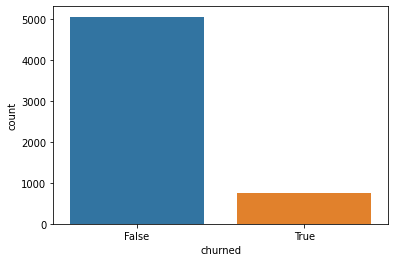

In [104]:
# Visualize the count of customer churn::
sns.countplot(df['churned'])

In [105]:
# What is the percentage of customer that are leaving:
num_reteined = df[df['churned'] == False].shape[0]
num_churned = df[df['churned'] == True].shape[0]

print(num_reteined / (num_reteined + num_churned) * 100, '% of customer stayed with the company.')
print(num_churned / (num_reteined + num_churned) * 100, '% of customer churned.')

87.07342295760083 % of customer stayed with the company.
12.926577042399174 % of customer churned.


In [106]:
mrr_reteined = np.where(df['churned'] == False, df['mrr'],0).sum()
mrr_churned = np.where(df['churned'] == True, df['mrr'],0).sum()

print(mrr_reteined / (mrr_reteined + mrr_churned) * 100, '% of MRR stayed with the company.')
print(mrr_churned / (mrr_reteined + mrr_churned) * 100, '% of MRR churned.')

87.87967593509015 % of MRR stayed with the company.
12.120324064909843 % of MRR churned.


In [107]:
df['first_subscription_start_dt'] = pd.to_datetime(df['first_subscription_start_dt'])
df['terminated_dt'] = pd.to_datetime(df['terminated_dt'])
df['reference_dt'] = pd.to_datetime(df['reference_dt'])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5802 entries, 0 to 5801
Data columns (total 31 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   domain_name                  5802 non-null   object        
 1   is_fleet                     5802 non-null   bool          
 2   domain_status                5802 non-null   object        
 3   first_subscription_start_dt  5802 non-null   datetime64[ns]
 4   terminated_dt                750 non-null    datetime64[ns]
 5   reference_dt                 5802 non-null   datetime64[ns]
 6   mrr                          5802 non-null   float64       
 7   mrr_logbook                  5802 non-null   float64       
 8   mrr_admin                    5802 non-null   float64       
 9   mrr_geo                      5802 non-null   float64       
 10  mrr_pro                      5802 non-null   float64       
 11  mrr_fsk                      5802 non-null 

In [108]:
# Drop columns which are not relevant
df.drop(columns = ['is_fleet', 'sat_score_cs', 'sat_score_other', 'tickets_cs_last7d_amt' ,'tickets_other_last7d_amt'], inplace = True)

<AxesSubplot:xlabel='days_retained', ylabel='mrr'>

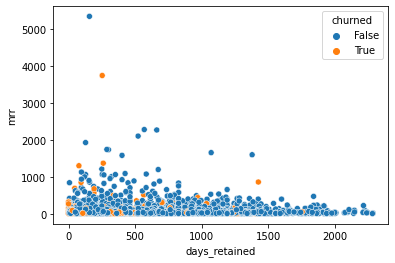

In [109]:
sns.scatterplot(data=df, x="days_retained", y="mrr", hue="churned")

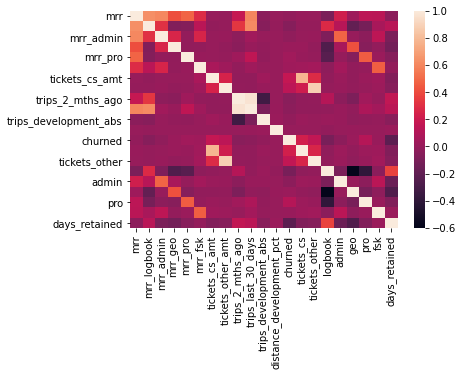

In [110]:
sns.heatmap(df.corr());

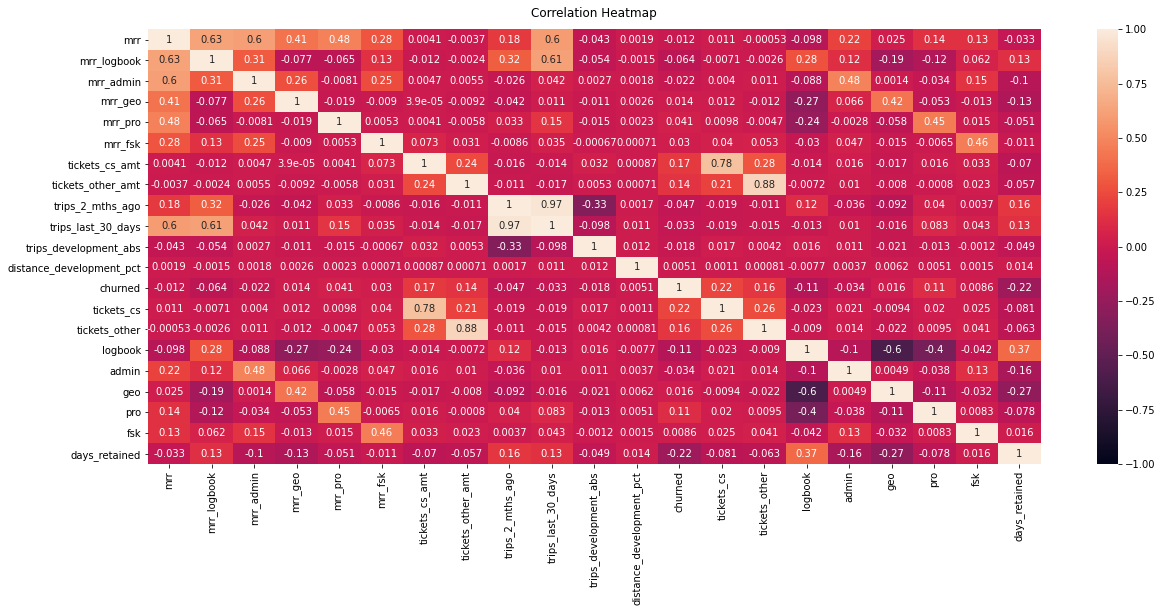

In [111]:
# Increase the size of the heatmap.
plt.figure(figsize=(20, 8))

# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='churned', ylabel='count'>

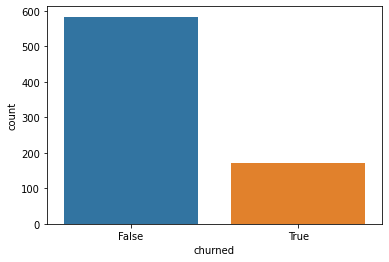

In [112]:
# Pro licenses customers:
df_pro = df[df['pro'] == 1]
sns.countplot(df_pro['churned'])

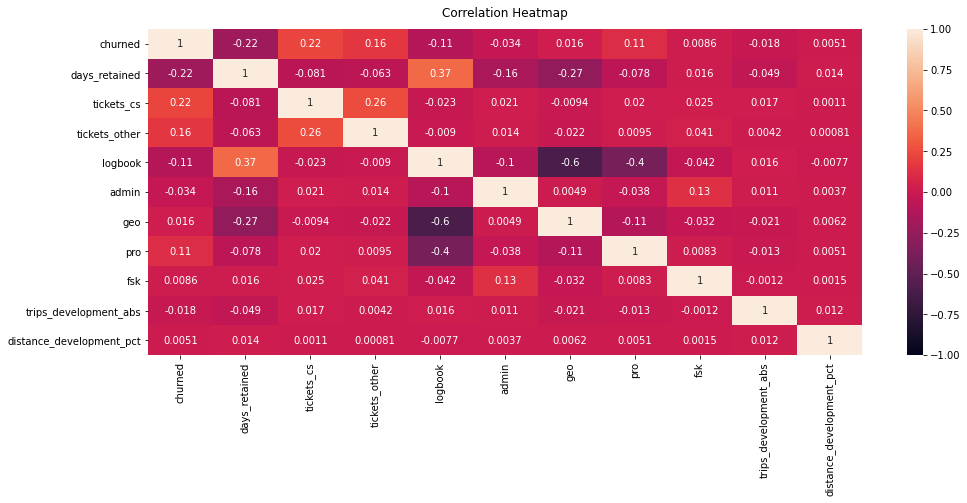

In [113]:
df_categorical = df[['churned','days_retained','tickets_cs', 'tickets_other', 
                 'logbook','admin','geo', 'pro', 'fsk', 'trips_development_abs', 'distance_development_pct']]

# Increase the size of the heatmap.
plt.figure(figsize=(16, 6))

# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(df_categorical.corr(), vmin=-1, vmax=1, annot=True)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

<AxesSubplot:>

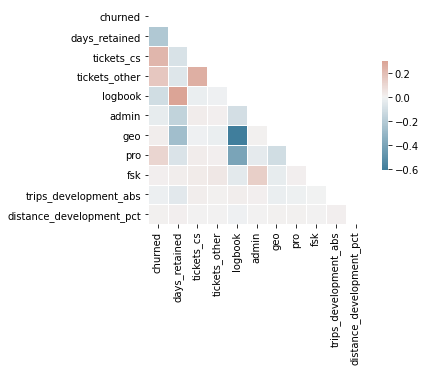

In [114]:
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(df_categorical.corr(), dtype=bool))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(df_categorical.corr(), mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Cleaned / ML

In [120]:
df_cleaned = df[['churned','days_retained','tickets_cs', 'tickets_other', 
                 'mrr', 'mrr_logbook','mrr_admin','mrr_geo', 'mrr_pro', 'mrr_fsk',
                'trips_development_abs', 'distance_development_pct']]
df_cleaned.head()

,churned,days_retained,tickets_cs,tickets_other,mrr,mrr_logbook,mrr_admin,mrr_geo,mrr_pro,mrr_fsk,trips_development_abs,distance_development_pct
0,False,1102,False,False,40.55,40.55,0.0,0.0,0.0,0.0,-25.0,0.0
1,False,426,False,False,15.90,15.90,0.0,0.0,0.0,0.0,0.0,0.0
2,False,196,False,False,19.90,19.90,0.0,0.0,0.0,0.0,0.0,0.0
3,True,604,False,False,15.90,15.90,0.0,0.0,0.0,0.0,0.0,0.0
4,False,280,False,False,15.90,15.90,0.0,0.0,0.0,0.0,-2.0,-100.0


In [121]:
df_cleaned.describe()

,days_retained,mrr,mrr_logbook,mrr_admin,mrr_geo,mrr_pro,mrr_fsk,trips_development_abs,distance_development_pct
count,5802.000000,5802.000000,5802.000000,5802.000000,5802.000000,5802.000000,5802.000000,5802.000000,5.802000e+03
mean,621.846260,72.956603,41.040493,4.833469,11.968314,13.783063,0.867285,-2.143571,-6.434686e+03
std,450.893709,151.986735,86.681570,35.564641,61.038918,79.107873,16.176703,111.568042,4.879401e+05
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-4394.000000,-3.716677e+07
25%,259.000000,19.900000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
50%,538.000000,38.080000,19.900000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
75%,897.000000,71.550000,42.930000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
max,2288.000000,5344.000000,2035.200000,1461.600000,3057.300000,2271.680000,855.000000,1830.000000,1.000000e+02


In [117]:
# Convert all of the non-numeric columns to numeric:
for column in df_cleaned.columns:
    if df_cleaned[column].dtype == np.number:
        df_cleaned[column] = df_cleaned[column].astype(np.int64)
        
    df_cleaned[column] = LabelEncoder().fit_transform(df_cleaned[column])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  This is separate from the ipykernel package so we can avoid doing imports until


In [122]:
df_cleaned.describe()

,days_retained,mrr,mrr_logbook,mrr_admin,mrr_geo,mrr_pro,mrr_fsk,trips_development_abs,distance_development_pct
count,5802.000000,5802.000000,5802.000000,5802.000000,5802.000000,5802.000000,5802.000000,5802.000000,5.802000e+03
mean,621.846260,72.956603,41.040493,4.833469,11.968314,13.783063,0.867285,-2.143571,-6.434686e+03
std,450.893709,151.986735,86.681570,35.564641,61.038918,79.107873,16.176703,111.568042,4.879401e+05
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-4394.000000,-3.716677e+07
25%,259.000000,19.900000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
50%,538.000000,38.080000,19.900000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
75%,897.000000,71.550000,42.930000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
max,2288.000000,5344.000000,2035.200000,1461.600000,3057.300000,2271.680000,855.000000,1830.000000,1.000000e+02


In [123]:
# Can be removed later, only for testing:
df_churned = df_cleaned[df_cleaned['churned'] == True]
df_churned = df_cleaned.iloc[[3,5,9,22,23]]
df_churned

,churned,days_retained,tickets_cs,tickets_other,mrr,mrr_logbook,mrr_admin,mrr_geo,mrr_pro,mrr_fsk,trips_development_abs,distance_development_pct
3,True,604,False,False,15.90,15.9,0.0,0.0,0.00,0.0,0.0,0.0
5,True,162,False,False,38.93,0.0,0.0,0.0,38.93,0.0,-149.0,-100.0
9,True,394,False,False,63.60,63.6,0.0,0.0,0.00,0.0,-72.0,-52.0
22,True,565,False,False,516.00,0.0,0.0,516.0,0.00,0.0,0.0,0.0
23,True,302,False,False,12.90,0.0,0.0,12.9,0.00,0.0,0.0,0.0


In [124]:
# Can be removed later, only for testing:
df_cleaned = df_cleaned.merge(df_churned, how = 'outer' ,indicator=True).loc[lambda x : x['_merge']=='left_only']
df_cleaned = df_cleaned.iloc[: , :-1]

In [125]:
# Split features and target
X = df_cleaned.drop('churned', axis=1)  # Features data set
y = df_cleaned['churned']  # Target data set

In [126]:
# Scaled the data
X = StandardScaler().fit_transform(X)

In [127]:
# Split the data into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [128]:
# Create the model
model = LogisticRegression()
# Train the model
model.fit(X_train, y_train)

LogisticRegression()

In [129]:
# Create the predictions on the test data
predictions = model.predict(X_test)

print(predictions)

[False False False ... False False False]


In [130]:
# Check the precision, recall, f1-score
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

       False       0.87      1.00      0.93      1000
        True       1.00      0.09      0.16       160

    accuracy                           0.87      1160
   macro avg       0.94      0.54      0.55      1160
weighted avg       0.89      0.87      0.83      1160



In [131]:
cross_val_score(model, X, y, cv=5, scoring='accuracy').mean()

0.8813177233643747

In [132]:
y.value_counts(normalize=True)

False    0.871485
True     0.128515
Name: churned, dtype: float64

In [133]:
df_pred = pd.DataFrame(model.predict(X_test))
df_pred.head()

,0
0,False
1,False
2,False
3,False
4,False


In [134]:
df_X_test = pd.DataFrame(X_test)
df_y_test = pd.DataFrame(y_test)
# df_out = pd.merge(df_X_test, y_test,  left_index=True, right_index=True)
df_out = pd.merge(df_X_test, df_pred, how='left', left_index=True, right_index=True)
df_out = pd.merge(df_out, df_y_test, how='left', left_index=True, right_index=True)



In [135]:
df_y_test.describe

<bound method NDFrame.describe of       churned
3738    False
4468    False
817     False
2632    False
2123    False
...       ...
4772    False
612     False
4006     True
4676     True
3213    False

[1160 rows x 1 columns]>

In [136]:
# Can be removed later, testing only:
df_churned = df_churned.iloc[: , 1:]
df_churned

,days_retained,tickets_cs,tickets_other,mrr,mrr_logbook,mrr_admin,mrr_geo,mrr_pro,mrr_fsk,trips_development_abs,distance_development_pct
3,604,False,False,15.90,15.9,0.0,0.0,0.00,0.0,0.0,0.0
5,162,False,False,38.93,0.0,0.0,0.0,38.93,0.0,-149.0,-100.0
9,394,False,False,63.60,63.6,0.0,0.0,0.00,0.0,-72.0,-52.0
22,565,False,False,516.00,0.0,0.0,516.0,0.00,0.0,0.0,0.0
23,302,False,False,12.90,0.0,0.0,12.9,0.00,0.0,0.0,0.0


In [140]:
# Can be removed later, testing only:
predictions_2 = model.predict(test)

print(predictions_2)

[False False False False False]


In [138]:
pd.DataFrame(X_test)

,0,1,2,3,4,5,6,7,8,9,10
0,-0.822729,-0.086447,-0.061721,-0.394988,-0.473583,-0.135978,0.016682,-0.174240,-0.053641,0.314621,0.013260
1,-0.561075,-0.086447,-0.061721,-0.270583,-0.106824,-0.135978,-0.195841,-0.174240,-0.053641,0.063693,0.013329
2,0.177319,-0.086447,-0.061721,-0.375241,-0.290203,-0.135978,-0.195841,-0.174240,-0.053641,0.619318,0.013303
3,0.363581,-0.086447,-0.061721,-0.291515,-0.143500,-0.135978,-0.195841,-0.174240,-0.053641,0.018885,0.013194
4,0.263798,-0.086447,-0.061721,-0.173626,0.063062,-0.135978,-0.195841,-0.174240,-0.053641,0.018885,0.013194
...,...,...,...,...,...,...,...,...,...,...,...
1155,-0.543336,-0.086447,-0.061721,-0.375241,-0.290203,-0.135978,-0.195841,-0.174240,-0.053641,0.216042,0.013239
1156,0.290406,-0.086447,-0.061721,-0.375241,-0.290203,-0.135978,-0.195841,-0.174240,-0.053641,-0.375430,0.012789
1157,-1.281730,-0.086447,-0.061721,0.504151,-0.473583,-0.135978,-0.195841,1.714969,-0.053641,1.739530,0.013245
1158,-0.802772,-0.086447,-0.061721,-0.291515,-0.143500,-0.135978,-0.195841,-0.174240,-0.053641,0.018885,0.013194


In [139]:
test = StandardScaler().fit_transform(df_churned)
test

array([[ 1.20873423,  0.        ,  0.        , -0.58500562,  0.        ,
         0.        , -0.51557034, -0.5       ,  0.        ,  0.74463554,
         0.75607856],
       [-1.48139935,  0.        ,  0.        , -0.46637258, -0.64549722,
         0.        , -0.51557034,  2.        ,  0.        , -1.76556119,
        -1.73102197],
       [-0.06938354,  0.        ,  0.        , -0.33929151,  1.93649167,
         0.        , -0.51557034, -0.5       ,  0.        , -0.46834543,
        -0.53721371],
       [ 0.9713695 ,  0.        ,  0.        ,  1.99112905, -0.64549722,
         0.        ,  1.99940693, -0.5       ,  0.        ,  0.74463554,
         0.75607856],
       [-0.62932084,  0.        ,  0.        , -0.60045934, -0.64549722,
         0.        , -0.45269591, -0.5       ,  0.        ,  0.74463554,
         0.75607856]])